In [2]:
import os
import io
import cv2
import ast
import json
import time
import torch
import base64
import anybadge
import requests
import pytesseract
import numpy as np

from torch import nn
from typing import Tuple
from pytesseract import Output
from collections import Counter
from torchvision import transforms as T
from jinja2 import Environment, FileSystemLoader
from PIL import Image,ImageDraw,ImageOps,ImageFilter
from torchvision.models.mobilenetv3 import mobilenet_v3_large



In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.preprocess = T.Compose([T.Resize(768),T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.layer_name = "features.16.0"
        self.model = mobilenet_v3_large(True).eval()
        self.hooked = {}
        
    def forward(self,x):
        hook = self.model.features[16][0].register_forward_hook(self._forward_hook)
        tensor = self.preprocess(x).unsqueeze(0)
        output = self.model(tensor)
        feature = self.hooked['output']
        h,w = output.shape
        hook.remove()
        _, _, vT = torch.linalg.svd(feature)
        v1 = vT[:, :, 0, :][..., None, :]
        heatmap = feature @ v1.repeat(1, 1, v1.shape[3], 1)
        heatmap = heatmap.sum(1)
        heatmap -= heatmap.min()
        heatmap = heatmap / heatmap.max() * 255
        return heatmap
    
    def _forward_hook(self, module, inputs: Tuple[torch.Tensor], outputs):
        self.hooked['output'] = outputs


In [6]:
def image_to_base64(img):
    buffered = io.BytesIO()
    img.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

In [7]:
def overlay(heatmap,img,colormap=cv2.COLORMAP_JET):
    if not isinstance(heatmap, np.ndarray):
        heatmap = np.asarray(heatmap)

    cam = cv2.resize(heatmap, img.size)
    cam = cv2.applyColorMap(cam, colormap)        

    if not isinstance(img, np.ndarray):
        img = np.asarray(img)

    overlay = np.uint8(0.6 * img + 0.4 * cam)
    return Image.fromarray(overlay)

In [8]:
def get_text_rectangles(pillow_img):
    d = pytesseract.image_to_data(pillow_img, output_type=Output.DICT)
    n_boxes = len(d['text'])
    rectangles = []
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            rectangles.append((x, y, x + w, y + h,d['text'][i]))
    return rectangles

In [9]:
def get_ctas(rectangles,apikey):
    words = [rectangle[-1] for rectangle in rectangles]
    sentences = "','".join(words)
    sentences = "'"+sentences+"'"
    text = f"""
        Which of the following words below are most likely to be Call to Actions on a website. Output a list of words as a Python list.
        {sentences}
    """
    prompt = {"contents": [{
            "parts":[{
                "text": text}]
                }]
    }
    api = f'https://generativelanguage.googleapis.com/v1/models/gemini-pro:generateContent?key={apikey}'
    response = requests.post(api, 
        json=prompt,
        headers={"Content-Type": "application/json"},
    )
    item = response.json()
    ctas = ast.literal_eval(item['candidates'][0]['content']['parts'][0]['text'])
    rectangular_details = [rectangle + (True,) if rectangle[-1].lower() in [cta.lower() for cta in ctas] else rectangle + (False,) for rectangle in rectangles]
    return rectangular_details #list of text coordinates with CTA flags


In [10]:
def get_summary(issues,apikey):
    sentences = "\n".join(issues)
    text = f"""
        The following are webpage issues from an A11y accessibility test. Provide a summary of the issues on the webpage as an HTML paragraph. Be as succinct as possible.
        {sentences}
    """
    prompt = {"contents": [{
            "parts":[{
                "text": text}]
                }]
    }
    api = f'https://generativelanguage.googleapis.com/v1/models/gemini-pro:generateContent?key={apikey}'
    response = requests.post(api, 
        json=prompt,
        headers={"Content-Type": "application/json"},
    )
    item = response.json()
    summary = item['candidates'][0]['content']['parts'][0]['text']
    return summary #list of text coordinates with CTA flags


In [11]:
def draw_ctas(img,rectangles,padding=4,sigma=16,flag=False):
    new = Image.new('RGBA', img.size, (0, 0, 0, 0))
    copy = img.copy()
    drawing = ImageDraw.Draw(new)
    for rectangle in rectangles:
        (x1, y1, x2, y2, text, cta) = rectangle
        if cta is True or flag is True:
            # drawing.rectangle((x1-padding, y1-padding, x2+padding, y2+padding), outline=(160, 32, 240), fill=(160,32,240,127), width=3)
            drawing.rectangle((x1-padding, y1-padding, x2+padding, y2+padding), outline=(160, 32, 240), fill=(255,255,255,255), width=5)
    # out = Image.alpha_composite(copy.convert("RGBA"), new)
    smoothed = new.convert("L").filter(ImageFilter.GaussianBlur(sigma))
    return smoothed

In [12]:
def calculate_iou(im1, im2):
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)
    im2 = (im2) * 1
    im1 = (im1) * 1

    overlap = im2 * im1  # Logical AND
    union = (im2 + im1)>0  # Logical OR
    iou = overlap.sum() / float(union.sum())
    return iou

In [13]:
def calculate_dice(im1, im2, empty_score=1.0):
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / im_sum

In [14]:
def attentivity_metric(im1,im2):
    return calculate_dice(im1,im2) #im1 and im2 are gemini cta map and pytorch heatmap respectively

def usability_metric(im1,im2):
    return calculate_iou(im1,im2) #im1 and im2 are gemini cta map and pytorch heatmap respectively

def clutter_metric(im1,im2):
    return calculate_dice(im1,im2) #im1 and im2 are gemini cta map and gemini overall heatmap respectively

In [15]:
model = Net()
state_dict = torch.load("webheatmap/weights.pth",map_location="cpu")
model.load_state_dict(state_dict=state_dict)
apiKey = os.environ.get("GEMINI_API_KEY")

/Users/bitan/.pyenv/versions/3.10.4/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/Users/bitan/.pyenv/versions/3.10.4/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
img = Image.open("screen.png").convert("RGB")

In [17]:
heatmap = model(T.ToTensor()(img)).cpu().detach().numpy().transpose(1, 2, 0).astype("uint8")

/Users/bitan/.pyenv/versions/3.10.4/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [18]:
im_pred = ImageOps.invert(Image.fromarray(heatmap.squeeze(),"L").resize(img.size))

In [19]:
overlaid = overlay(heatmap,img)

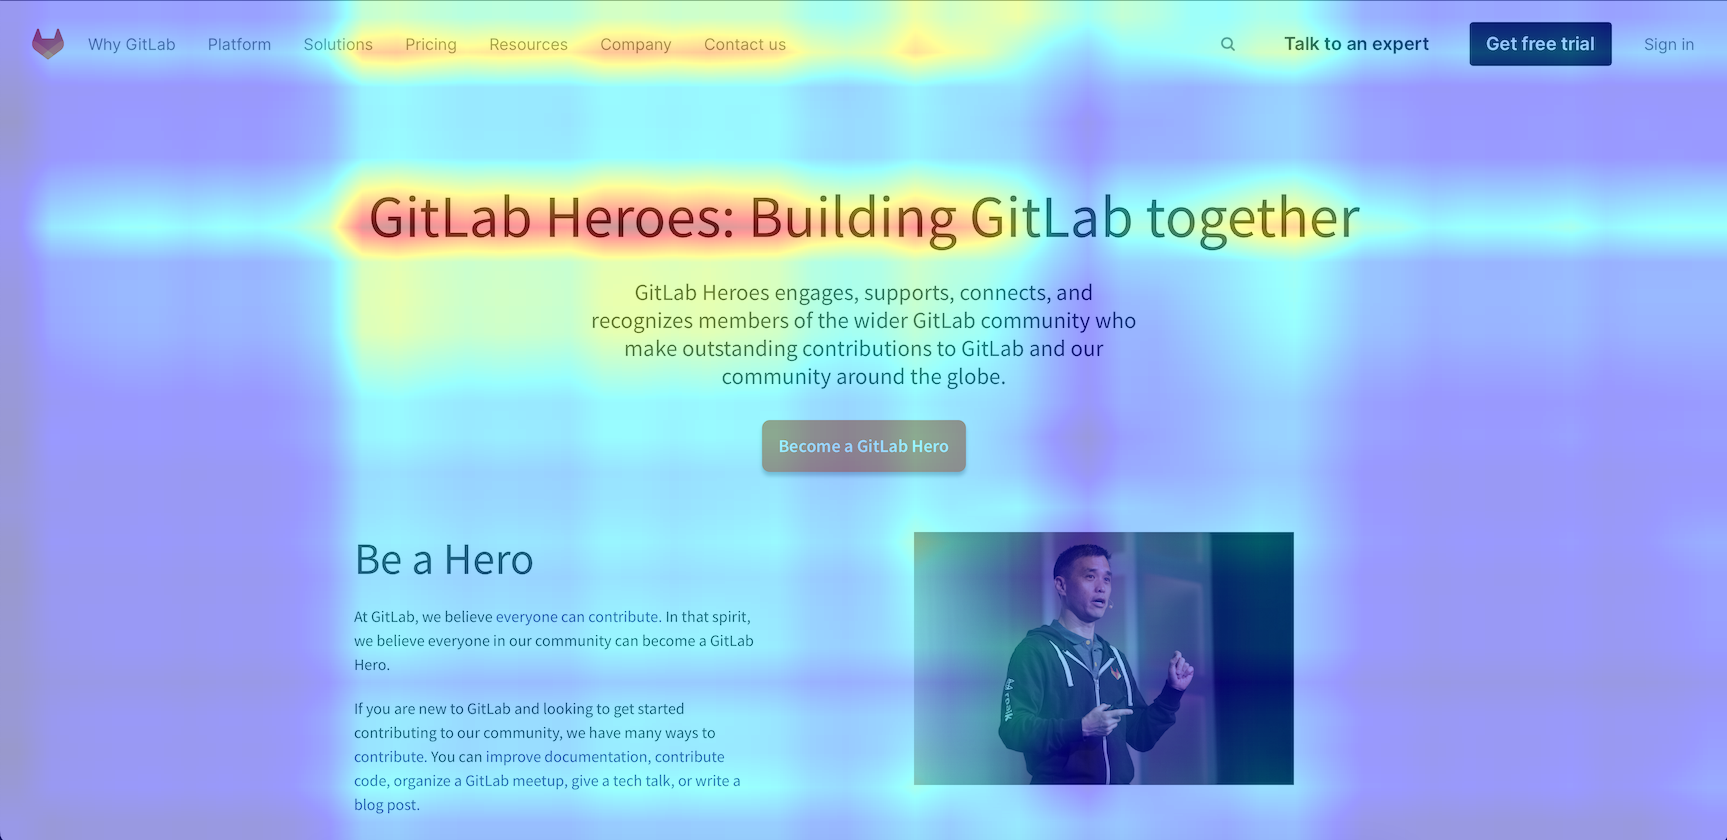

In [20]:
overlaid

In [21]:
rects = get_text_rectangles(img)

In [22]:
cta_rects = get_ctas(rects,apiKey)

In [23]:
ctaed = draw_ctas(img,cta_rects,sigma=5)
im_true = ctaed.copy()

In [24]:
im_overall = draw_ctas(img,cta_rects,sigma=5,flag=True)

In [25]:
composited = Image.composite(img,overlaid,ctaed)

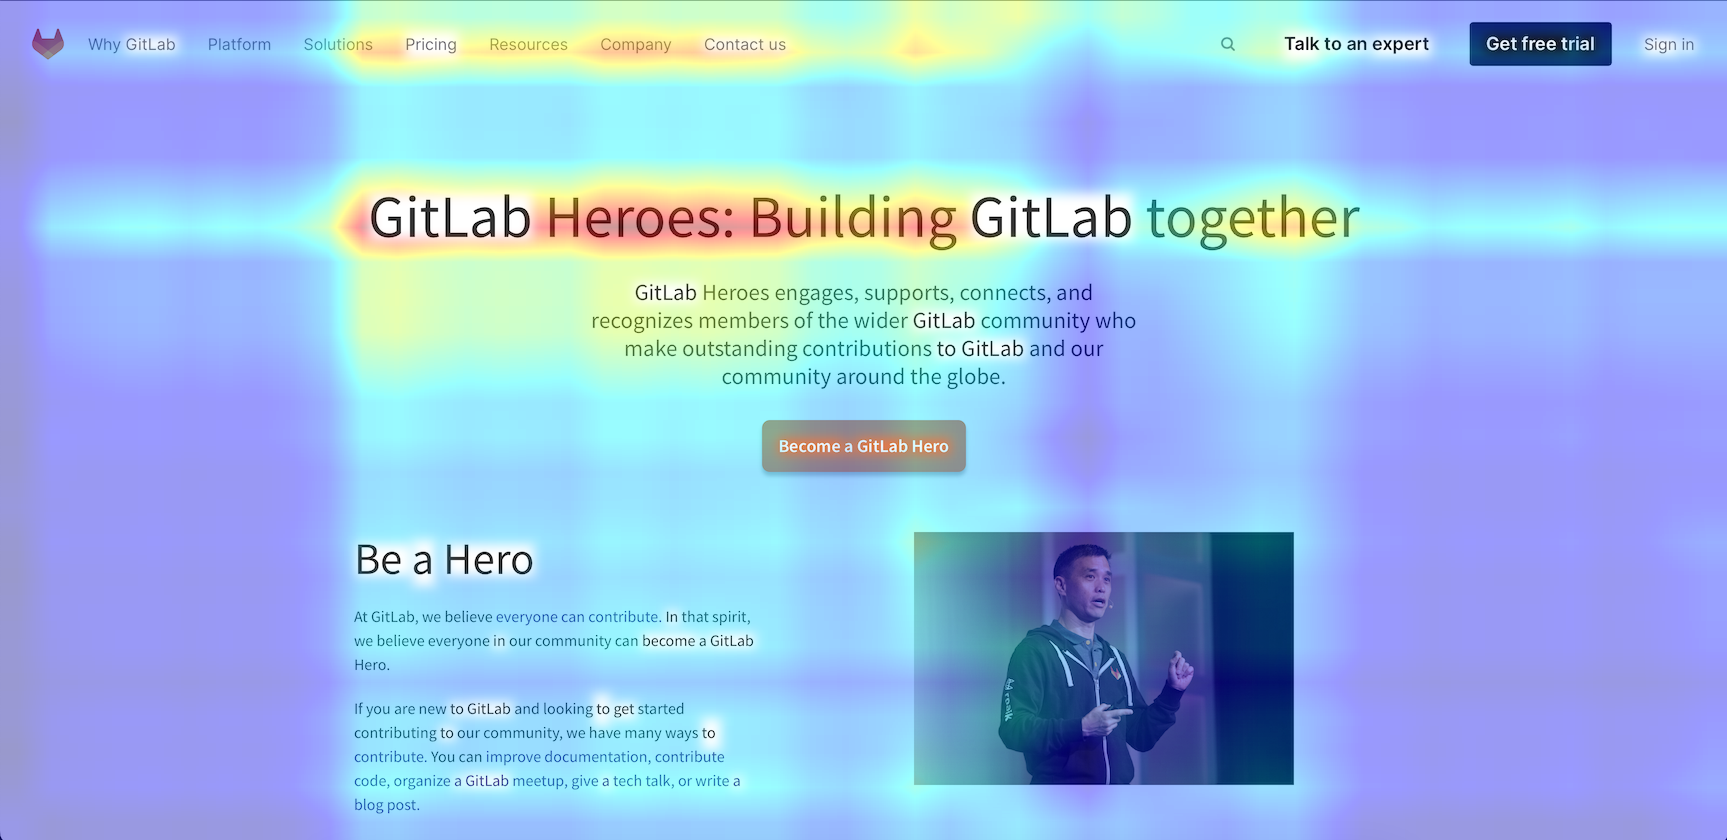

In [26]:
composited

In [27]:
print("attentivity_metric",attentivity_metric(im_true,im_pred),"usability_metric",usability_metric(im_true,im_pred),"clutter_metric",clutter_metric(im_overall,im_true))

attentivity_metric 0.1537657130265432 usability_metric 0.08328613227014232 clutter_metric 0.418403066600122


In [28]:
(0.13987096277426828*0.07519422576343264*0.38558922535099155) ** (1./3)

0.1594699955123582

Now to create a Jinja template exposing these metrics along with a text summary and issues, and finally an anybadge

In [29]:
with open('pally_output.json') as f:
    pallyOutput = json.load(f)

In [30]:
url = list(pallyOutput["results"].keys())[0]
total = pallyOutput["errors"]

In [31]:
runners = [a["runner"] for a in pallyOutput["results"][url]]

In [32]:
",".join(list(set(runners)))

'htmlcs'

In [33]:
obj = {}
obj["url"] = url
obj["heatmap"] ='data:image/jpeg;base64,'+image_to_base64(composited)
obj["runners"] = ",".join(list(set(runners)))
obj["date"] = time.ctime(time.time())
obj["usability"] = round(usability_metric(im_true,im_pred)*100 + 50,2) 
obj["attentivity"] = round(attentivity_metric(im_true,im_pred)*100 + 50,2)
obj["clutter"] = round(clutter_metric(im_overall,im_true)*100 + 50,2) 
obj["score"] = round((obj["usability"]*obj["attentivity"]*obj["clutter"]) ** (1./3),2)
obj["ally"] = {}
obj["ally"]["issues"] = []
obj["ally"]["total"] = total
all_issues = []

In [34]:
rawissues = Counter([a["code"]+"|"+a["message"] for a in pallyOutput["results"][url]])

In [35]:
for k,v in rawissues.items():
    issue_rule,issue_text = k.split("|")
    issue_count = v
    issue = {"rule":issue_rule,"count":issue_count,"text":issue_text}
    obj["ally"]["issues"].append(issue)
    all_issues.append(issue_text)

In [36]:
for i,issue in enumerate(obj["ally"]["issues"]):
    list_of_selectors = [a["selector"] for a in pallyOutput["results"][url] if issue["rule"] == a["code"]] 
    obj["ally"]["issues"][i]["elements"] = " and ".join(list_of_selectors)
    obj["ally"]["issues"][i]["elements_count"] = len(list_of_selectors)

In [37]:
obj["ally"]["summary"] = get_summary(all_issues,apiKey)

In [47]:
file_loader = FileSystemLoader('./webheatmap')
env = Environment(loader=file_loader)


In [48]:
template = env.get_template('template.jinja')

In [49]:
html = template.render(obj=obj)

In [50]:
with open("GFG-1.html","w")  as f:
    f.write(html)
    f.close()